In [46]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [47]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [48]:
for col in train.columns:
    if train[col].dtype == 'object':
        train[col] = train[col].astype('category')
        test[col] = test[col].astype('category')
        le = LabelEncoder()
        le.fit(list(train[col].values) + list(test[col].values))
        train[col] = le.transform(list(train[col].values))
        test[col] = le.transform(list(test[col].values))

In [7]:
train.isna().sum()

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64

In [49]:
# filling missing values
cat_columns = train.select_dtypes(include=['category']).columns
train[cat_columns].fillna(-1, inplace=True)
test[cat_columns].fillna(-1, inplace=True)

/tmp/ipykernel_3015/3900774008.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[cat_columns].fillna(-1, inplace=True)
/tmp/ipykernel_3015/3900774008.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[cat_columns].fillna(-1, inplace=True)


In [37]:
na_cols = train.columns[train.isna().any()]
na_cols

Index(['LotFrontage', 'MasVnrArea', 'GarageYrBlt'], dtype='object')

In [39]:
na_cols = train.columns[train.isna().any()]
na_cols

Index([], dtype='object')

In [50]:
na_cols = train.columns[train.isna().any()]
# fill with mean
train.fillna(train.mean(), inplace=True)
test.fillna(test.mean(), inplace=True)


In [51]:
train.drop(['Id'], axis=1, inplace=True)
test.drop(['Id'], axis=1, inplace=True)
target = train['SalePrice']
train.drop(['SalePrice'], axis=1, inplace=True)

In [52]:
X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=0.2, random_state=42)


In [53]:
# linear regression
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train)
# mse
pred = lr.predict(X_test)
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, pred)
print(mse)
rmse = mse ** 0.5
print(rmse)


1198333565.074149
34616.95487870285


In [60]:
# huber regression
from sklearn.linear_model import HuberRegressor
huber = HuberRegressor()
huber.fit(X_train, y_train)
pred = huber.predict(X_test)
mse = mean_squared_error(y_test, pred)
print(mse)
rmse = mse ** 0.5
print(rmse)


1842007334.5765874
42918.612915337646


/home/ubuntu/miniconda3/envs/stat/lib/python3.10/site-packages/sklearn/linear_model/_huber.py:332: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [59]:
# ridge regression
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=2000)
ridge.fit(X_train, y_train)
pred = ridge.predict(X_test)
mse = mean_squared_error(y_test, pred)
print(mse)
rmse = mse ** 0.5
print(rmse)

1289004648.161156
35902.71087482331


In [54]:
# lightgbm
import lightgbm as lgb
lgb_train = lgb.Dataset(X_train, y_train)
lgb_test = lgb.Dataset(X_test, y_test)
params = {
    'n_estimators': 1000,
    'boosting_type': 'dart',
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.1,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}
model = lgb.train(params, lgb_train, num_boost_round=1000, valid_sets=lgb_test, early_stopping_rounds=50,verbose_eval=0)
pred = model.predict(X_test)
mse = mean_squared_error(y_test, pred)
print("MSE: %f" % mse)
rmse = mse ** 0.5
print("RMSE: %f" % rmse)

/home/ubuntu/miniconda3/envs/stat/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/ubuntu/miniconda3/envs/stat/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ubuntu/miniconda3/envs/stat/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/home/

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001108 seconds.
You can set `force_col_wise=true` to remove the overhead.
MSE: 676424401.661501
RMSE: 26008.160290


In [55]:
submission = pd.read_csv('sample_submission.csv')
submission['SalePrice'] = model.predict(test)
submission.to_csv('submission.csv', index=False)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

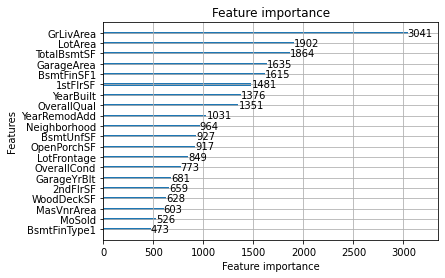

In [57]:
lgb.plot_importance(model, max_num_features=20)
